# Imports

In [1]:
!pip install statsforecast

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from   scipy import stats

In [3]:
plt.rcParams["figure.figsize"] = 12,6

## Read Data

In [5]:
data_path   = "./data/"
sales       = pd.read_excel(data_path + "sales.xlsx", index_col="DateId", parse_dates=True)
sales.head()

,DistributorId,CustomerId,Channel-Id,ProductId,ProductBasePrice,DiscountRate,Amount,Total,InvoiceTip
DateId,,,,,,,,,
2020-04-09,10,36485,274,12555,9.52,0,960,9139.20,SELLING
2020-04-09,10,36485,274,12557,13.62,0,1392,18959.04,SELLING
2020-04-09,10,36485,274,12563,23.92,0,816,19518.72,SELLING
2020-04-09,10,36485,274,12565,16.36,0,1200,19632.00,SELLING
2020-04-09,10,36487,274,12596,6.74,0,24,161.76,SELLING


In [26]:
categories  = pd.read_excel(data_path + "categories.xlsx")
categories.columns = ("ProductId", "Category")
categories

,ProductId,Category
0,12555,PEST CONTROL
1,12557,PEST CONTROL
2,12563,PEST CONTROL
3,12565,PEST CONTROL
4,12566,PEST CONTROL
5,12569,PEST CONTROL
6,12588,HOME CLEANERS
7,12596,HOME CLEANERS
8,12659,HOME CLEANERS
9,12660,HOME CLEANERS


In [28]:
sales

,DistributorId,CustomerId,Channel-Id,ProductId,ProductBasePrice,DiscountRate,Amount,Total,InvoiceTip
DateId,,,,,,,,,
2020-04-09,10,36485,274,12555,9.52,0,960,9139.20,SELLING
2020-04-09,10,36485,274,12557,13.62,0,1392,18959.04,SELLING
2020-04-09,10,36485,274,12563,23.92,0,816,19518.72,SELLING
2020-04-09,10,36485,274,12565,16.36,0,1200,19632.00,SELLING
2020-04-09,10,36487,274,12596,6.74,0,24,161.76,SELLING
...,...,...,...,...,...,...,...,...,...
2023-04-13,91,76224,275,68499,37.18,0,36,1338.48,SELLING
2023-04-13,91,76224,275,71182,52.43,0,259,13579.37,SELLING
2023-04-13,91,76224,275,75035,52.43,0,258,13526.94,SELLING


In [31]:
sales = pd.merge(left=sales.reset_index(), right=categories, on="ProductId", how="left").set_index("DateId")

## Investigate Data

In [32]:
# Check nullity
sales.isna().sum()

DistributorId       0
CustomerId          0
Channel-Id          0
ProductId           0
ProductBasePrice    0
DiscountRate        0
Amount              0
Total               0
InvoiceTip          0
Category            0
dtype: int64

In [51]:
# Check duplicates
duplicate_check_sales         = sales.copy()
duplicate_check_sales["Date"] = duplicate_check_sales.index
print(duplicate_check_sales.duplicated().sum(), "duplicates")

del duplicate_check_sales

0 duplicates


In [34]:
sales["InvoiceTip"].value_counts(normalize=True)

InvoiceTip
SELLING           0.976066
SELLING_RETURN    0.023934
Name: proportion, dtype: float64

In [35]:
def plot_amount_with_selling_type(sales, lower_limit=None, upper_limit=None, plot_lim=None, title="Untitled"):
    size = 10
    
    selling_data = sales.query("InvoiceTip == 'SELLING'")

    if lower_limit:
        plt.axhline(lower_limit, color="black")

    if upper_limit:
        plt.axhline(upper_limit, color="black")
    
    plt.scatter(x=selling_data.index, 
                y=selling_data["Amount"].values,
                s=size, 
                label="Selling")
    
    selling_data = sales.query("InvoiceTip == 'SELLING_RETURN'")
    plt.scatter(x=selling_data.index, 
                y=selling_data["Amount"].values,
                s=size, 
                label="Return")
    
    plt.xlabel("Date")
    plt.ylabel("Amount")
    
    if plot_lim:
        plt.ylim(-plot_lim, plot_lim)
        
    plt.title(title)
    plt.legend()
    plt.show()

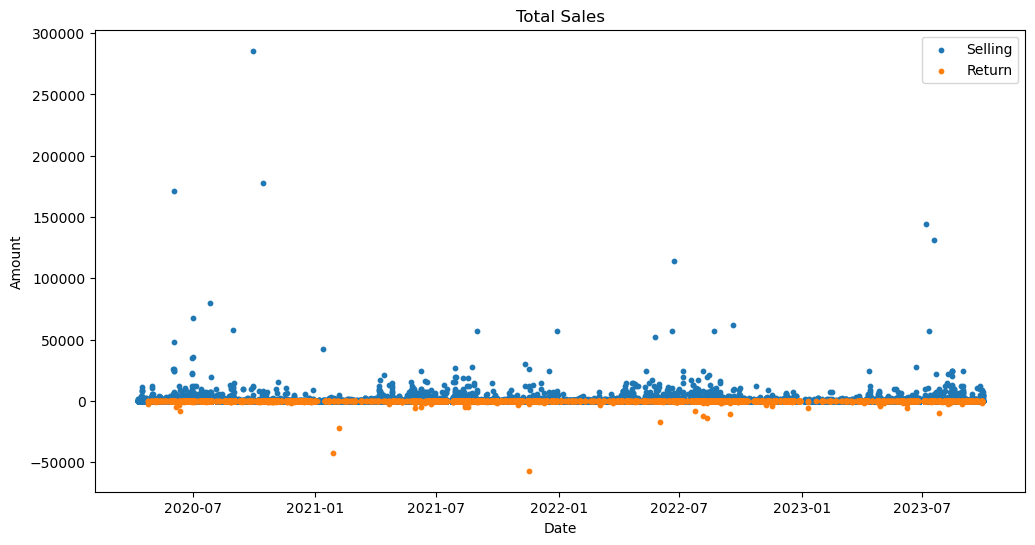

In [36]:
plot_amount_with_selling_type(sales, title="Total Sales")

## Outlier Detection

In [37]:
mean        = sales["Amount"].mean()
std         = sales["Amount"].std()

z_limit     = 10
z_threshold = mean + z_limit * std
print(z_threshold)

15668.171336451449


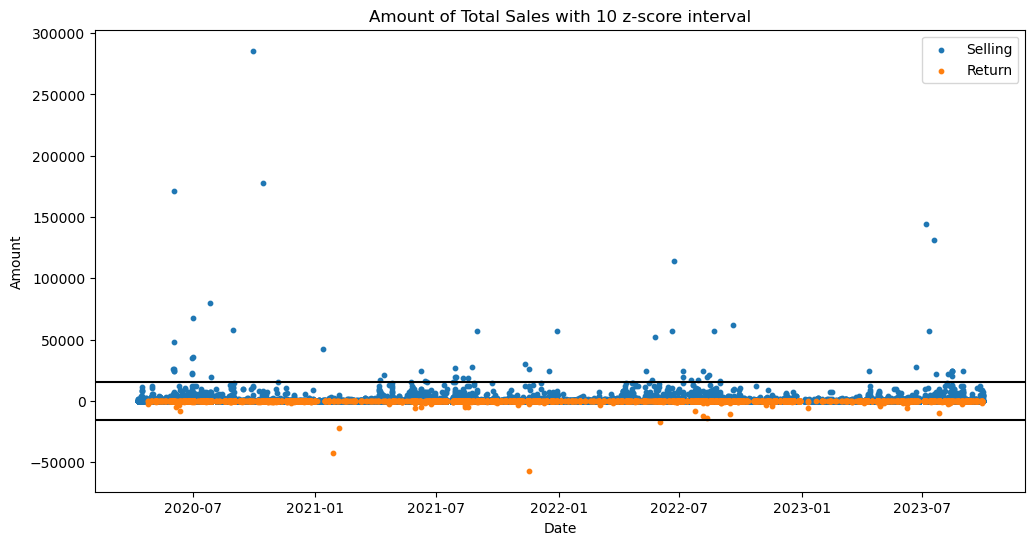

In [38]:
plot_amount_with_selling_type(sales, lower_limit=-z_threshold, upper_limit=z_threshold, 
                              title=f"Amount of Total Sales with {z_limit} z-score interval")

In [39]:
# Check outliers

outlier_data = sales.query("Amount > @z_threshold or Amount < -@z_threshold").copy()
inlier_data  = sales.drop(outlier_data.index)
print(f"{round(len(outlier_data) / len(sales), 4)} of data is considered as outlier at {z_limit} * std level.")
print(
f"""
Mean before filtering = {sales["Amount"].mean()}
Mean after filtering  = {inlier_data["Amount"].mean()}
""")

0.0005 of data is considered as outlier at 10 * std level.

Mean before filtering = 123.48310991957105
Mean after filtering  = 98.90161228096935



Frequenct of products in outlier data

In [40]:
outlier_data["ProductId"].value_counts().head()

ProductId
12555    46
12569    11
12659     1
12596     1
12557     1
Name: count, dtype: int64

### Endog. outliers

In [46]:
# Z Score of Amount by ProductId
sales['AmountZScore'] = sales.groupby('ProductId')['Amount'].transform(stats.zscore)

In [47]:
sales["AmountZScore"].isna().sum()

0

In [48]:
# Endogenous Outlier Detection
outlier_ratio_per_product = (
    sales[sales["AmountZScore"] > z_limit].groupby("ProductId")["AmountZScore"].count().sort_values(ascending=False) / 
    sales["ProductId"].value_counts()).rename("ratio").fillna(0)
outlier_info_sales = pd.merge(left=outlier_ratio_per_product, 
                           right=sales["ProductId"].value_counts(), 
                           right_index=True,
                           left_index= True,
                           how="outer")
outlier_info_sales.sort_values(by="count", ascending=False).head()

,ratio,count
ProductId,,
12555,0.000921,17381
12569,0.001533,10440
12557,0.002024,10373
12565,0.000739,8118
12563,0.000902,7762


In [49]:
filtered_sales = sales[sales["AmountZScore"].abs() < z_limit].copy()
filtered_sales.describe()

,DistributorId,CustomerId,Channel-Id,ProductId,ProductBasePrice,DiscountRate,Amount,Total,AmountZScore
count,122885.000000,122885.000000,122885.000000,122885.000000,122885.000000,122885.000000,122885.000000,1.228850e+05,122885.000000
mean,34.044879,41712.162770,273.924271,20802.660089,31.408382,3.024128,101.483167,2.939140e+03,-0.024882
std,20.142145,13837.569005,1.615534,19908.600570,25.719343,5.184620,590.368394,1.889902e+04,0.599170
min,10.000000,20465.000000,272.000000,12555.000000,3.850000,0.000000,-22056.000000,-3.933120e+05,-9.971100
25%,19.000000,36435.000000,272.000000,12563.000000,13.850000,0.000000,9.000000,1.881600e+02,-0.209489
50%,33.000000,37825.000000,274.000000,12588.000000,23.740000,0.000000,15.000000,4.556000e+02,-0.140100
75%,38.000000,41965.000000,274.000000,13405.000000,41.010000,4.000000,48.000000,1.394400e+03,-0.078065
max,91.000000,80906.000000,280.000000,83624.000000,623.820000,107.000000,34560.000000,2.277531e+06,9.910688


## Feature Engineering and Product Filtering

In [52]:
first_date_in_sales, last_date_in_sales = filtered_sales.index.min(), filtered_sales.index.max()
filtered_sales["DaystoLastDateInSales"]  = (last_date_in_sales - filtered_sales.index).days 

In [53]:
print(f"First sale on {first_date_in_sales.date()} \nLast sale on  {last_date_in_sales.date()}")
print(f"Windows is {round((last_date_in_sales - first_date_in_sales).days / 364, 2)} years")

First sale on 2020-04-09 
Last sale on  2023-09-30
Windows is 3.49 years


### Product Details and Eligible Products

In [54]:
outlier_info_sales.columns = ["Outlier Ratio", "Outlier Count"]
outlier_info_sales.head()

,Outlier Ratio,Outlier Count
ProductId,,
12555,0.000921,17381
12557,0.002024,10373
12563,0.000902,7762
12565,0.000739,8118
12566,0.001913,5749


In [62]:
inactive_threshold = 364
long_enough        = 364
min_sales          = 100
date_quantile      = .95

filtered_sales["Date"] = pd.to_datetime(filtered_sales.index)

product_details                                 = filtered_sales.groupby("ProductId")["Date"].agg(["min", "max"])
product_details.columns                         = ["FirstSaleDate", "LastSaleDate"]

# Date Related
product_details["DaysSoldFor"]                  = (product_details["LastSaleDate"] - product_details["FirstSaleDate"]).dt.days
product_details["DaysSinceLastSaleDate"]        = (last_date_in_sales - product_details["LastSaleDate"]).dt.days

# Validity of the product
product_details["IsActive"]                     = product_details["DaysSinceLastSaleDate"].apply(lambda day: day < inactive_threshold)
product_details["IsSoldEnough"]                 = product_details["DaysSoldFor"].apply(lambda days: days > long_enough)

# Sales volume
product_details["TotalSaleAmount"]              = filtered_sales.groupby("ProductId")["Amount"].sum()
product_details["MeanSaleAmountPerMonth"]       = product_details["TotalSaleAmount"] / (product_details["DaysSoldFor"] / 30)

# Maybe we can add quantile test?

query_              = """IsActive               == True and \
                         IsSoldEnough           == True and \
                         MeanSaleAmountPerMonth >= @min_sales
                      """
eligible_products                               = product_details.query(query_).copy()

print(f"{eligible_products.count().min()} of {len(sales.ProductId.unique())} products are eligible for forecasting.")

del filtered_sales["Date"]

26 of 29 products are eligible for forecasting.


In [63]:
product_details

,FirstSaleDate,LastSaleDate,DaysSoldFor,DaysSinceLastSaleDate,IsActive,IsSoldEnough,TotalSaleAmount,MeanSaleAmountPerMonth
ProductId,,,,,,,,
12555,2020-04-09,2023-09-30,1269,0,True,True,4623122,109293.664303
12557,2020-04-09,2023-09-30,1269,0,True,True,865486,20460.661939
12563,2020-04-09,2023-09-29,1268,1,True,True,468414,11082.350158
12565,2020-04-09,2023-09-30,1269,0,True,True,443283,10479.503546
12566,2020-04-14,2023-09-29,1263,1,True,True,219960,5224.703088
12569,2020-04-09,2023-09-30,1269,0,True,True,1831444,43296.548463
12588,2020-04-09,2023-09-26,1265,4,True,True,157405,3732.924901
12596,2020-04-09,2023-09-30,1269,0,True,True,625456,14786.193853
12659,2020-04-09,2023-09-30,1269,0,True,True,521095,12319.030733


83149, 83616, 83624 are not suitable for forecasting since they haven't been sold for more than one year.

<Axes: xlabel='DateId'>

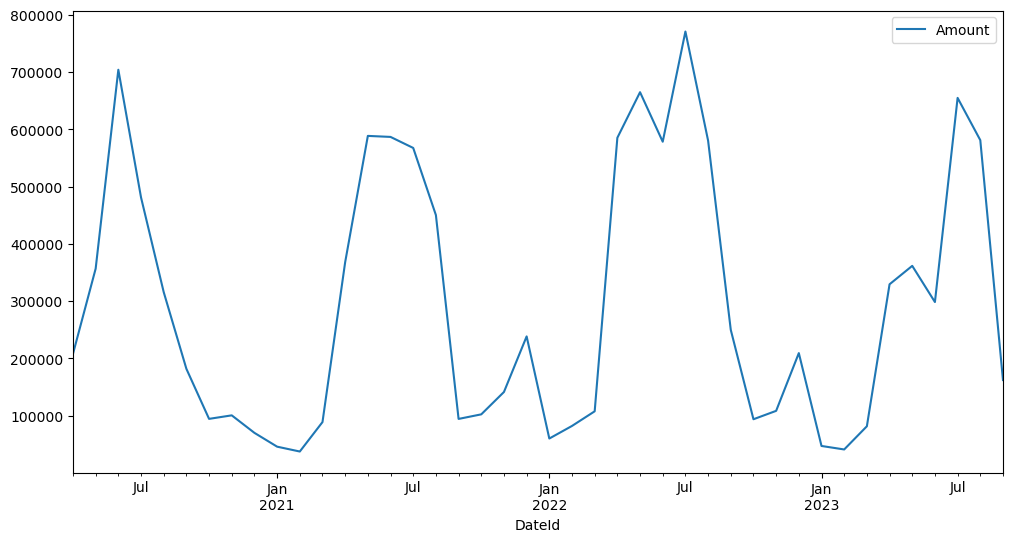

In [85]:
monthly_resample = filtered_sales.resample("MS")
total_agg = monthly_resample[["Amount"]].sum().copy()
total_agg.plot()

# Forecasting

In [445]:
pest_control_agg = filtered_sales.query("Category== 'PEST CONTROL' ").resample("MS").Amount.sum()

In [446]:
def split_dataset(data, horizon, timeshift=0):
    data = data.reset_index()
    data.columns = ["ds", "y"]
    data["unique_id"] = 1
    
    train = data.iloc[:-(horizon + timeshift)]
    test  = data.iloc[-(horizon + timeshift):]
    return train,test

In [611]:
HORIZON = 6
TIMESHIFT = 12

In [612]:
train, test = split_dataset(total_agg, horizon=HORIZON, timeshift=TIMESHIFT)

In [613]:
from statsforecast import StatsForecast
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [614]:
from statsforecast.models import AutoETS, AutoCES, AutoARIMA, AutoTheta, SeasonalNaive, SeasonalWindowAverage, MSTL, AutoTBATS

In [615]:
sf = StatsForecast(
    models = [AutoETS(model="ANA", season_length = 12),
              AutoCES(model="N", season_length=12),
              AutoARIMA(season_length = 12),
              AutoTheta(season_length = 12, decomposition_type="additive"),
              SeasonalWindowAverage(season_length=12, window_size=2),
              MSTL(season_length=[12, 3]),
              AutoTBATS(seasonal_periods=[12])],
    freq = "MS")
sf.fit(train)

/opt/conda/lib/python3.11/site-packages/statsforecast/tbats.py:944: UserWarning: The time series is trend-stationary, disabling trend components.
  warnings.warn(


StatsForecast(models=[AutoETS,CES,AutoARIMA,AutoTheta,SeasWA,MSTL,AutoTBATS])

In [616]:
pred = sf.predict(h=HORIZON)

In [617]:
pred

,unique_id,ds,AutoETS,CES,AutoARIMA,AutoTheta,SeasWA,MSTL,AutoTBATS
0,1,2022-04-01,286897.81250,48804.847656,97947.640625,99961.125000,287989.0,379726.250000,186481.484375
1,1,2022-05-01,473624.84375,84789.820312,78135.632812,92646.757812,472681.0,579585.312500,297400.500000
2,1,2022-06-01,645376.25000,54987.042969,58279.082031,85332.390625,645486.0,722849.312500,386822.406250
3,1,2022-07-01,524554.18750,64113.601562,41768.644531,78018.023438,524396.5,613368.437500,382575.593750
4,1,2022-08-01,384710.71875,51261.214844,29172.763672,70703.656250,383071.0,484958.156250,288559.531250
5,1,2022-09-01,139195.87500,51774.433594,20019.093750,63389.285156,138071.0,214944.265625,178942.578125


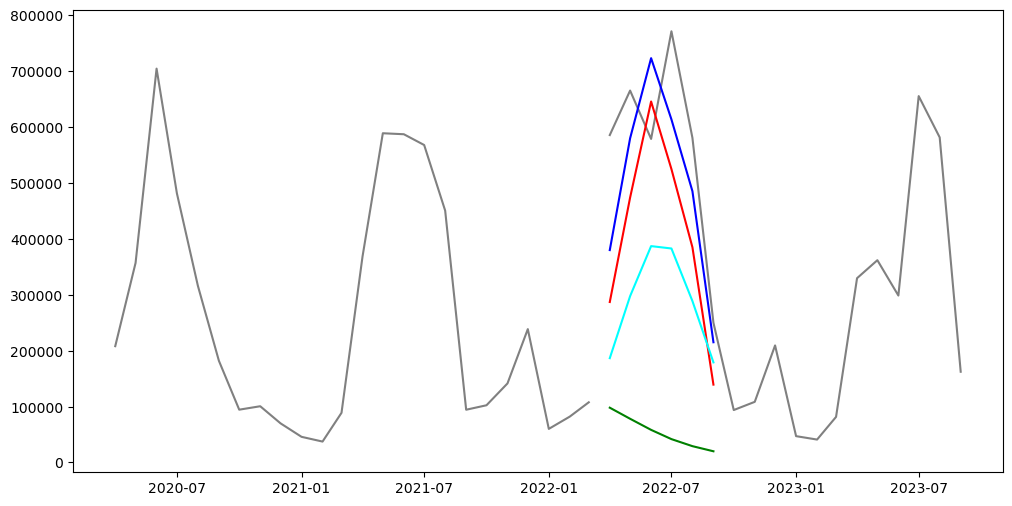

In [618]:
plt.plot(train["ds"], train["y"], color = "grey")
plt.plot(test["ds"], test["y"], color = "grey")
plt.plot(pred["ds"], pred["AutoETS"], color = "red")
plt.plot(pred["ds"], pred["AutoARIMA"], color = "green")
plt.plot(pred["ds"], pred["AutoTBATS"], color = "cyan")
plt.plot(pred["ds"], pred["MSTL"], color = "blue")

In [629]:
merged = pred.merge(right=test, on="ds")
error = (merged.AutoTBATS - merged.y).abs() / merged.y.mean()
error.mean()

AttributeError: 'DataFrame' object has no attribute 'AutoTBATS'

In [622]:
!pip install lightgbm
!pip install mlforecast

In [623]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences


In [624]:
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1)
]

fcst = MLForecast(
    models=models,
    freq='MS',
    date_features=['month'],
    target_transforms = [Differences([12])]
)


In [625]:
fcst.fit(train)

MLForecast(models=[LGBMRegressor], freq=MS, lag_features=[], date_features=['month'], num_threads=1)

In [626]:
pred = fcst.predict(6)

In [627]:
from utilsforecast.plotting import plot_series

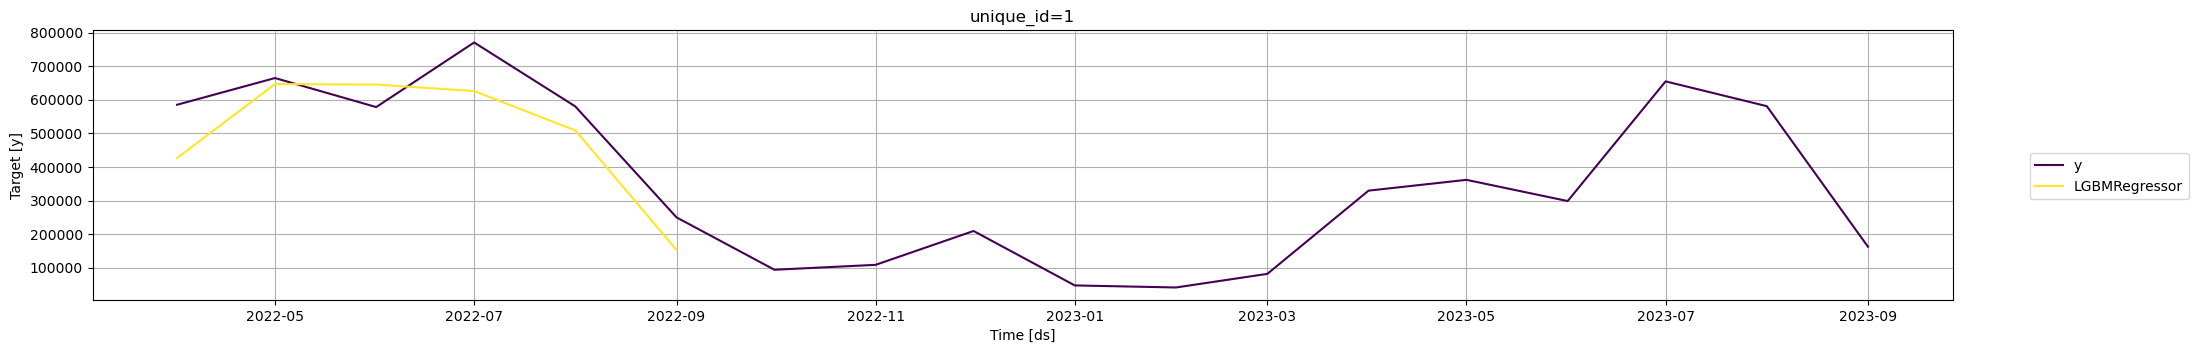

In [628]:
plot_series(test, pred)

In [630]:
pred

,unique_id,ds,LGBMRegressor
0,1,2022-04-01,426646.343750
1,1,2022-05-01,647201.312500
2,1,2022-06-01,645421.312500
3,1,2022-07-01,626163.312500
4,1,2022-08-01,508914.343750
5,1,2022-09-01,152893.328125


In [631]:
merged = pred.merge(right=test, on="ds")
error = (merged.LGBMRegressor - merged.y).abs() / merged.y.mean()
error.mean()

0.16226572649795676

In [632]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 6.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.1/328.1 kB 7.5 MB/s eta 0:00:00:00:01


In [644]:
from neuralforecast import NeuralForecast
from neuralforecast.models import AutoNHITS

ImportError: cannot import name 'AutoNHITS' from 'neuralforecast.models' (/opt/conda/lib/python3.11/site-packages/neuralforecast/models/__init__.py)

In [643]:
horizon = HORIZON

In [641]:
models = [AutoNBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
          AutoNHITS(input_size=2 * horizon, h=horizon, max_steps=50)]
nf = NeuralForecast(models=models, freq='MS')
nf.fit(df=train)
Y_hat_df = nf.predict().reset_index()

NameError: name 'AutoNBEATS' is not defined

In [640]:
merged = Y_hat_df.merge(right=test, on="ds")
error = (merged.NHITS - merged.y).abs() / merged.y.mean()
error.mean()

0.4417554795047745

In [639]:
Y_hat_df

,unique_id,ds,NBEATS,NHITS
0,1,2022-04-01,337688.812500,274271.40625
1,1,2022-05-01,510570.062500,466958.12500
2,1,2022-06-01,529560.500000,484560.53125
3,1,2022-07-01,506284.687500,462567.21875
4,1,2022-08-01,286309.375000,255032.78125
5,1,2022-09-01,44730.828125,-28682.81250
